In [1]:
## Import packages
import h5py                        
import matplotlib.pyplot as plt    
import numpy as np                 
import netCDF4
import glob
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import warnings
import datetime
import pickle
import geopandas as gp
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LightSource

import cartopy.crs as ccrs
from pyproj import CRS

from scipy.optimize import curve_fit

In [2]:
#function to get corresponding ALS file from given lat/lon [for plotting]
def get_als_file(lon,lat):
    
    with open('./input/als_filename_bounds.pkl','rb') as f:
        als_fnames = pickle.load(f)

    als_fnames = als_fnames[(als_fnames.min_lat < lat) & 
                           (als_fnames.max_lat > lat) & 
                           (als_fnames.min_lon < lon) &
                           (als_fnames.max_lon > lon)]
                            
    als_f = als_fnames.filename.iloc[0]
    
    with open(als_f):
        alsdata = netCDF4.Dataset(als_f)
        lat = np.asarray(alsdata['lat'])
        lon = np.asarray(alsdata['lon'])
        elev = np.asarray(alsdata['elevation'])
        xc = np.asarray(alsdata['xc'])
        yc = np.asarray(alsdata['yc'])
    
    int_elev = elev
    int_elev[np.isnan(int_elev)==True]=-2
    ls = LightSource(azdeg=270,altdeg=35)
    intensity = ls.hillshade(int_elev, vert_exag=2.5)
    intensity[int_elev==-2]=np.nan
    intensity[intensity<0.4]=np.nan
    
    return xc,yc,lon,lat,intensity    

## Functions to (attempt to) recreate the IS2 double gaussian fit
def double_gaussian( x, params ):
    (c1, mu1, sigma1, c2, mu2, sigma2) = params
    res =   c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) ) \
          + c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) )
    return res

def double_gaussian_fit( params ):
    fit = double_gaussian( x, params )
    return (fit - y)

### Load in geopandas dataframe

In [3]:
beam = 'gt2r'
with open('./input/pickle_files/data_'+beam+'.pkl','rb') as f:
    gdf = pickle.load(f)

### Load in IS2 data to get other params + flags

In [4]:
fname = "./input/ATL07-01_20200323105252_13400601_005_01.h5" 

dic = {}
with h5py.File(fname, "r") as f:
    df = pd.DataFrame()
    #height data
    df['height_segment_id'] = f[beam]["sea_ice_segments"]["height_segment_id"][:]
    df['ssh_flag'] = f[beam]["sea_ice_segments"]["heights"]["height_segment_ssh_flag"][:] #0 = sea ice, 1 = sea surface
    df['seg_len_across'] = f[beam]["sea_ice_segments"]["heights"]["across_track_distance"][:]
    df['seg_type'] = f[beam]["sea_ice_segments"]["heights"]["height_segment_type"][:]
    df['fit_qual'] = f[beam]["sea_ice_segments"]["heights"]["height_segment_fit_quality_flag"][:]
    df['seg_qual'] = f[beam]["sea_ice_segments"]["heights"]["height_segment_quality"][:] #seg quality incorporates fit quality!!
    df['w_gaussian'] = f[beam]["sea_ice_segments"]["heights"]["height_segment_w_gaussian"][:] #measure of roughness
    df['ATL_mss'] = f[beam]["sea_ice_segments"]["geophysical"]["height_segment_mss"][:]
    df['exmax_mix'] = f[beam]["sea_ice_segments"]["stats"]["exmax_mix"][:]
    df['exmax_mean_1'] = f[beam]["sea_ice_segments"]["stats"]["exmax_mean_1"][:]
    df['exmax_mean_2'] = f[beam]["sea_ice_segments"]["stats"]["exmax_mean_2"][:]
    df['exmax_stdev_1'] = f[beam]["sea_ice_segments"]["stats"]["exmax_stdev_1"][:]
    df['exmax_stdev_2'] = f[beam]["sea_ice_segments"]["stats"]["exmax_stdev_2"][:]
    df['trim_h_bot'] = f[beam]["sea_ice_segments"]["stats"]["trim_height_bottom"][:]
    df['trim_h_top'] = f[beam]["sea_ice_segments"]["stats"]["trim_height_top"][:]

df.loc[(df.w_gaussian > 200),'w_gaussian'] = np.nan #sometime W_gaussian explodes

### Merge DFs 

In [5]:
gdf = gdf.merge(df, on='height_segment_id')

## Get height histograms

Make ALS and IS2 histograms with given bounds from IS2. Normalize (Density=True)

In [6]:
als_hists = []
als_adj_hists = []
is2_hists = []
als_stds = [] #get STD of sfc heights as roughness estimate
is2_stds = []
als_medians = [] #get mean and median of ALS too, since ATL has them in data products
als_means = [] 
diffs = []
comp_w_gauss = []
for i,r in gdf.iterrows():
    #ALS hists
    ###########
    ##Offset to align ALS and ATL elevation - for now!
    diff = r.ATL_elevation - r.ALS_elevation
    diffs.append(diff)
    #########
    subset = r.pointsinside.elevation
    subset_adj = r.pointsinside.elevation + diff
    als_stds.append(np.nanstd(subset))
    als_medians.append(np.nanmedian(subset))
    als_means.append(np.nanmean(subset))
    hist_counts,hist_xvals = np.histogram(subset[np.isnan(subset)==0].ravel(),221,(r.hist_photon_bottom,r.hist_photon_top),density=True)
    als_hists.append(hist_counts)
    hist_counts,hist_xvals = np.histogram(subset_adj[np.isnan(subset_adj)==0].ravel(),221,(r.hist_photon_bottom,r.hist_photon_top),density=True)
    als_adj_hists.append(hist_counts)
    
    #IS2 hists - have it, just need to normalize
    height_bins = np.arange(r.hist_photon_bottom,r.hist_photon_top,r.hist_photon_bin_size) 
    counts = r.hist_photon_heights
    all_heights = []
    for ii,ph_h in enumerate(height_bins): #loops through each height bin to get all indiv. photons
        all_heights.extend([ph_h]*counts[ii])
    is2_stds.append(np.nanstd(all_heights))
    hist_counts_is2,__ = np.histogram(all_heights,221,(r.hist_photon_bottom,r.hist_photon_top),density=True)
    is2_hists.append(hist_counts_is2)
    
    #computing gaussian width - 
    #x = np.arange(r.hist_photon_bottom,r.hist_photon_top+r.hist_photon_bin_size,r.hist_photon_bin_size)
    #if len(x) == 222:
    #    x=x[:len(x)-1]
    #y = r.hist_photon_heights
    #fit = leastsq( double_gaussian_fit,[r.exmax_mix,r.exmax_mean_1,r.exmax_stdev_1,r.exmax_mix,r.exmax_mean_2,r.exmax_stdev_2])
    #fit_gauss = double_gaussian( x, fit[0] )
    #fit_gaussian = fit_double_gauss(,x,r.hist_photon_heights)
    #strt = x[0]+(r.hist_photon_bin_size/2)
    #stop = x[-1]+(r.hist_photon_bin_size/2)+r.hist_photon_bin_size
    #step = r.hist_photon_bin_size
    #mids = np.arange(strt,stop,step)
    #mean = np.average(mids, weights=fit_gauss)
    #var = np.average((mids - mean)**2, weights=fit_gauss)
    #comp_w = np.sqrt(var)
    #comp_w_gauss.append(comp_w)


/Users/sfons/anaconda3/envs/als/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


"Shift" all histograms so that every one has the same bounds (makes comparing easier across entire flightline)

In [7]:
max_range = np.arange(np.nanmin(gdf.hist_photon_bottom),np.nanmax(gdf.hist_photon_top)+.025,.025) #2.5cm bins
shifted_is2_hists = np.ones((len(gdf),len(max_range))) * np.nan
shifted_als_hists = np.ones((len(gdf),len(max_range))) * np.nan
shifted_als_adj_hists = np.ones((len(gdf),len(max_range))) * np.nan
for i,r in gdf.reset_index().iterrows():
    strt = np.where(max_range<= r.hist_photon_bottom)[0][-1]
    end=strt+221 #221 bins in IS2 histogram
    shifted_is2_hists[i,strt:end] = is2_hists[i]
    shifted_als_hists[i,strt:end] = als_hists[i]
    shifted_als_adj_hists[i,strt:end] = als_adj_hists[i]
    
extent = [np.arange(len(gdf))[0],np.arange(len(gdf))[-1],max_range[0],max_range[-1]]

Add values to dataframe

In [8]:
gdf['ALS_hist_normed'] = als_hists
gdf['ALS_hist_adj_normed'] = als_adj_hists
gdf['ALS_hist_normed_shifted'] = list(shifted_als_hists)
gdf['ALS_hist_adj_normed_shifted'] = list(shifted_als_adj_hists)
gdf['ALS_hist_std'] = als_stds
gdf['ALS_hist_mean'] = als_means
gdf['ALS_hist_median'] = als_medians
gdf['ATL_hist_normed'] = is2_hists
gdf['ATL_hist_normed_shifted'] = list(shifted_is2_hists)
gdf['ATL_hist_std'] = is2_stds
gdf['shifted_hist_extent'] = [extent] * len(gdf)
gdf['ALS_adj'] =diffs #amount to shift ALS to match IS2 - temporary
#gdf['computed_w_gauss'] = comp_w_gauss #only if computing own histogram width

## Plotting

A single example histogram from a given segment iloc [between 0 and len(gdf)]

/var/folders/rs/p1hd4ls52zvfb_p9m5_yjlvc_sh3jm/T/ipykernel_22172/3950138282.py:23: UserWarning: "true_scale_latitude" parameter is only used for polar stereographic projections. Consider the use of "scale_factor" instead.
  projection = ccrs.Stereographic(central_latitude=86.0, central_longitude=13.0, true_scale_latitude=70)


Beam: gt2r
Segment ID: 37943
Segment length: 14.113506
         N        Mean [m]       Median [m]     STD [m]     W. Gaussian [m]
IS2      20       0.04622        0.04724        0.27292        0.13599
ALS      1317     -0.5876        -0.6168        0.17282
ALS_shft 1317     0.03196        0.00270        0.17282


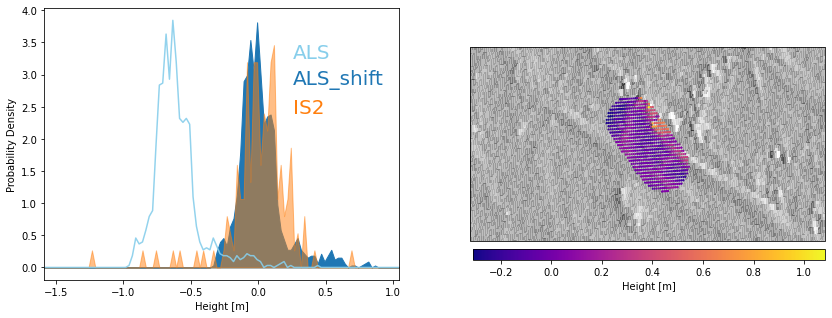

In [17]:
seg_loc = 100 #test segment
xc, yc,lonc,latc, alselev = get_als_file(gdf.longitude.iloc[seg_loc],gdf.latitude.iloc[seg_loc])
#setup colors
als_col = 'skyblue'
als_adj_col = 'tab:blue'
is2_col = 'tab:orange'

#plot histogram
fig,ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(max_range,shifted_als_hists[seg_loc],alpha=.9,c=als_col)
ax[0].fill_between(max_range,shifted_als_adj_hists[seg_loc],color=als_adj_col,alpha=1)
ax[0].fill_between(max_range,shifted_is2_hists[seg_loc],alpha=.5,color=is2_col)
#get bounds
lower = np.nanmin([gdf.hist_mean_h.iloc[seg_loc],gdf.ALS_hist_mean.iloc[seg_loc],gdf.ALS_hist_mean.iloc[seg_loc]+gdf.ALS_adj.iloc[seg_loc]])
upper = np.nanmax([gdf.hist_mean_h.iloc[seg_loc],gdf.ALS_hist_mean.iloc[seg_loc],gdf.ALS_hist_mean.iloc[seg_loc]+gdf.ALS_adj.iloc[seg_loc]])
ax[0].set_xlim([lower-1,upper+1])
ax[0].set_xlabel('Height [m]')
ax[0].set_ylabel('Probability Density')
ax[0].text(.7,.8,'ALS',ha='left',va='bottom',c=als_col,size=20,transform=ax[0].transAxes)
ax[0].text(.7,.7,'ALS_shift',ha='left',va='bottom',c=als_adj_col,size=20,transform=ax[0].transAxes)
ax[0].text(.7,.6,'IS2',ha='left',va='bottom',c=is2_col,size=20,transform=ax[0].transAxes)

projection = ccrs.Stereographic(central_latitude=86.0, central_longitude=13.0, true_scale_latitude=70)
ax[1].remove()
ax[1] = fig.add_subplot(1,2,2, projection=projection)

box_xmin = gdf.longitude.iloc[seg_loc]-.006
box_xmax = gdf.longitude.iloc[seg_loc]+.006
box_ymin = gdf.latitude.iloc[seg_loc]-.0002
box_ymax = gdf.latitude.iloc[seg_loc]+.0002

ax[1].set_extent([box_xmin, box_xmax, box_ymin, box_ymax],crs=ccrs.PlateCarree())
#ax[1].outline_patch.set_edgecolor('white')
ax[1].pcolormesh(lonc,latc,alselev,cmap="Greys",transform=ccrs.PlateCarree(),alpha=.5,snap=True,zorder=1)
#ax2.pcolormesh(ds.xc,ds.yc,np.array(ds.elevation),cmap=cmocean.cm.deep_r,alpha=0.2,transform=projection,snap=True)
scat = ax[1].scatter(gdf.pointsinside.iloc[seg_loc].lon,gdf.pointsinside.iloc[seg_loc].lat,
              c=gdf.pointsinside.iloc[seg_loc].elevation+gdf.ALS_adj.iloc[seg_loc] ,s=1,transform=ccrs.PlateCarree(),cmap='plasma',zorder=2)


cax = fig.add_axes([.55, 0.18, 0.35, 0.03])
cbar = fig.colorbar(scat, cax=cax, orientation='horizontal')
cbar.set_label('Height [m]')
## Print Stats
print('Beam: '+beam)
print('Segment ID: '+str(gdf.iloc[seg_loc].height_segment_id))
print('Segment length: '+str(gdf.iloc[seg_loc].height_segment_length_seg))
print('         N        Mean [m]       Median [m]     STD [m]     W. Gaussian [m]')
print('IS2      '+str(gdf.height_segment_n_pulse_seg_used.iloc[seg_loc])+'       '+str(gdf.hist_mean_h.iloc[seg_loc])[:7]+'        '+str(gdf.hist_median_h.iloc[seg_loc])[:7]+'        '+str(gdf.ATL_hist_std.iloc[seg_loc])[:7]+'        '+str(gdf.w_gaussian.iloc[seg_loc])[:7])
print('ALS      '+str(gdf.n_pointsinside.iloc[seg_loc])+'     '+str(gdf.ALS_hist_mean.iloc[seg_loc])[:7]+'        '+str(gdf.ALS_hist_median.iloc[seg_loc])[:7]+'        '+str(gdf.ALS_hist_std.iloc[seg_loc])[:7])
print('ALS_shft '+str(gdf.n_pointsinside.iloc[seg_loc])+'     '+str(gdf.ALS_hist_mean.iloc[seg_loc]+gdf.ALS_adj.iloc[seg_loc])[:7]+'        '+str(gdf.ALS_hist_median.iloc[seg_loc]+gdf.ALS_adj.iloc[seg_loc])[:7]+'        '+str(gdf.ALS_hist_std.iloc[seg_loc])[:7])

The entire flight as a height profile and single distribution:

        Beam: gt2r      N        Mean [m]       Median [m]     STD [m]     W. Gaussian [m]
               IS2      11122    0.12361        0.06187        0.22842        0.16040
               ALS      11122    -1.6535        -1.4729        0.85962


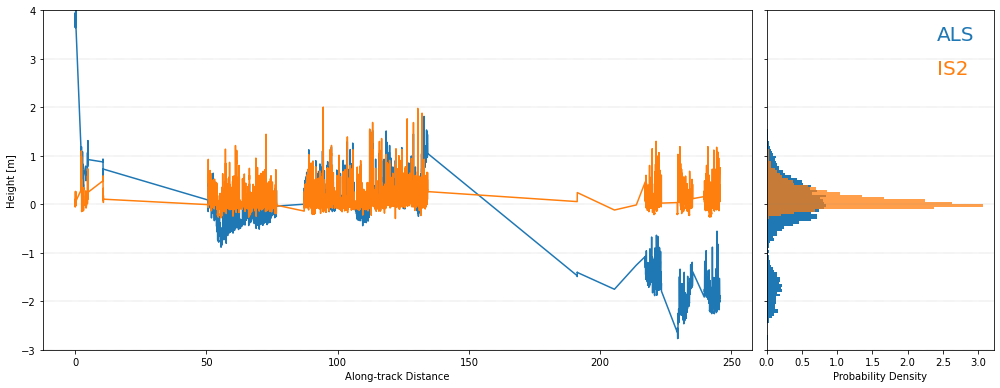

In [19]:
#adding in a shift of 1.44m to entire flightline
fig,axs = plt.subplots(1,4,figsize=(14,5.5),sharey=True)
gs = axs[0].get_gridspec()
for a in axs[0:3]:
    a.remove()
ax = ["",""]
ax[0] = fig.add_subplot(gs[0:3])
ax[1] = axs[3]
als_hist,hist_xvals = np.histogram(gdf.ALS_elevation,len(max_range),(max_range[0],max_range[-1]),density=True)
atl_hist,hist_xvals = np.histogram(gdf.ATL_elevation,len(max_range),(max_range[0],max_range[-1]),density=True)
ax[0].plot(gdf.distance_along_track/1000,gdf.ALS_elevation+1.44)
ax[0].plot(gdf.distance_along_track/1000,gdf.ATL_elevation)
ax[0].set_ylim([-3,4])
ax[1].set_ylim([-3,4])
ax[1].hist(gdf.ALS_elevation+1.44,125,[-4,2.25],density=True,orientation='horizontal',alpha=1)
ax[1].hist(gdf.ATL_elevation,125,[-4,2.25],density=True,orientation='horizontal',alpha=.75)
ax[0].grid(axis='y',color='grey', linestyle=':', linewidth=.4)
ax[1].grid(axis='y',color='grey', linestyle=':', linewidth=.4)
ax[0].set_xlabel('Along-track Distance')
ax[1].set_xlabel('Probability Density')
ax[0].set_ylabel('Height [m]')
#ax[0].set_xlim([90,100])
ax[1].text(.75,.9,'ALS',ha='left',va='bottom',c='tab:blue',size=20,transform=ax[1].transAxes)
ax[1].text(.75,.8,'IS2',ha='left',va='bottom',c='tab:orange',size=20,transform=ax[1].transAxes)
fig.tight_layout()

## Print Stats
print('        Beam: '+beam+'      N        Mean [m]       Median [m]     STD [m]     W. Gaussian [m]')
print('               IS2      '+str(gdf.ATL_elevation.count())+'    '+str(np.nanmean(gdf.ATL_elevation))[:7]+'        '+str(np.nanmedian(gdf.ATL_elevation))[:7]+'        '+str(np.nanstd(gdf.ATL_elevation))[:7]+'        '+str(np.nanmean(gdf.w_gaussian))[:7])
print('               ALS      '+str(gdf.ALS_elevation.count())+'    '+str(np.nanmean(gdf.ALS_elevation))[:7]+'        '+str(np.nanmedian(gdf.ALS_elevation))[:7]+'        '+str(np.nanstd(gdf.ALS_elevation))[:7])


All histograms throughout the flightline

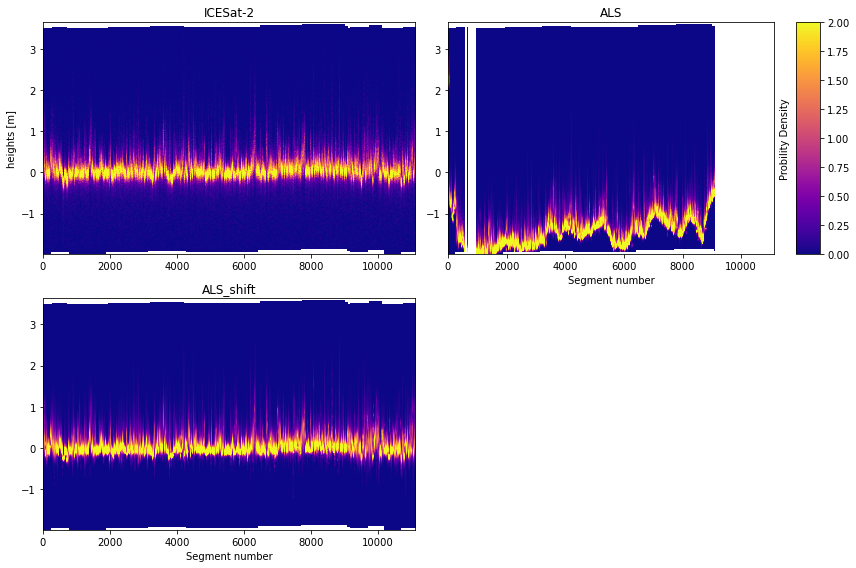

In [12]:
fig,axs = plt.subplots(2,2,figsize=(12,8))
ax = axs.ravel()
im = ax[0].imshow(np.flipud(shifted_is2_hists.T),extent=extent,aspect='auto',clim=(0,2),cmap='plasma')
ax[0].set_ylabel('heights [m]')
ax[0].set_title('ICESat-2')
ax[1].imshow(np.flipud(shifted_als_hists.T),extent=extent,aspect='auto',clim=(0,2),cmap='plasma')
ax[2].imshow(np.flipud(shifted_als_adj_hists.T),extent=extent,aspect='auto',clim=(0,2),cmap='plasma')
ax[1].set_title('ALS')
ax[2].set_title('ALS_shift')
ax[2].set_xlabel('Segment number')
ax[1].set_xlabel('Segment number')
ax[3].axis('off')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='7.5%', pad=0.30)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('Probility Density',labelpad=-70)
plt.tight_layout()